In [ ]:
#| hide
#| default_exp shell

# shell

> A shell for running notebook code without a notebook server

In [ ]:
#| export
from __future__ import annotations

from fastcore.utils import *
from fastcore.script import call_parse
from fastcore.ansi import ansi2html, strip_ansi

import multiprocessing,types,traceback,signal
try:
    if sys.platform == 'darwin': multiprocessing.set_start_method("fork")
except RuntimeError: pass # if re-running cell

from IPython.core.interactiveshell import InteractiveShell, ExecutionInfo, ExecutionResult
from IPython.core.displayhook import DisplayHook
from IPython.utils.capture import capture_output
from IPython.core.completer import IPCompleter,provisionalcompleter,Completer
from IPython.core.hooks import CommandChainDispatcher
from IPython.core.completerlib import module_completer
from IPython.utils.strdispatch import StrDispatch
from IPython.display import display as disp, HTML

from base64 import b64encode
from html import escape
try: from matplotlib_inline.backend_inline import set_matplotlib_formats
except ImportError: set_matplotlib_formats = None


from execnb.nbio import *
from execnb.nbio import _dict2obj


In [ ]:
from fastcore.test import *
from base64 import b64decode
from io import BytesIO
from PIL import Image

## CaptureShell -

In [ ]:
#| export
class _CustDisplayHook(DisplayHook):
    def write_output_prompt(self): pass
    def write_format_data(self, data, md_dict): pass
    def log_output(self, format_dict): pass

@patch
def __repr__(self: ExecutionInfo): return f'cell: {self.raw_cell}; id: {self.cell_id}'

@patch
def __repr__(self: ExecutionResult): return f'result: {self.result}; err: {self.error_in_exec}; info: <{self.info}>'

In [ ]:
#| export
class CaptureShell(InteractiveShell):
    displayhook_class = _CustDisplayHook

    def __init__(self, path:str|Path=None, mpl_format='retina', history=False, timeout:Optional[int]=None):
        super().__init__()
        self.history_manager.enabled = history
        self.timeout = timeout
        self.result,self.exc = None,None
        if path: self.set_path(path)
        self.display_formatter.active = True
        if not IN_NOTEBOOK: InteractiveShell._instance = self
        if set_matplotlib_formats:
            self.enable_matplotlib("inline")
            self._run("from matplotlib_inline.backend_inline import set_matplotlib_formats")
            self._run(f"set_matplotlib_formats('{mpl_format}')")

    def _run(self, raw_cell, store_history=False, silent=False, shell_futures=True, cell_id=None,
                 stdout=True, stderr=True, display=True, verbose=False):
        # TODO what if there's a comment?
        semic = raw_cell.rstrip().endswith(';')
        with capture_output(display=display, stdout=stdout and not verbose, stderr=stderr and not verbose) as c:
            result = super().run_cell(raw_cell, store_history, silent, shell_futures=shell_futures, cell_id=cell_id)
        return AttrDict(result=result, stdout='' if semic else c.stdout, stderr=c.stderr,
                        display_objects=c.outputs, 
                        exception=result.error_in_exec or result.error_before_exec, quiet=semic)
    
    def set_path(self, path):
        "Add `path` to python path, or `path.parent` if it's a file"
        path = Path(path)
        if path.is_file(): path = path.parent
        self._run(f"import sys; sys.path.insert(0, '{path.as_posix()}')")
    
    def enable_gui(self, gui=None): pass

In [ ]:
#| export
@patch
def run_cell(self:CaptureShell, raw_cell, store_history=False, silent=False, shell_futures=True, cell_id=None,
             stdout=True, stderr=True, display=True, timeout=None, verbose=False):
    if not timeout: timeout = self.timeout
    if timeout:
        def handler(*args): raise TimeoutError()
        signal.signal(signal.SIGALRM, handler)
        signal.alarm(timeout)
    try: return self._run(raw_cell, store_history, silent, shell_futures, cell_id=cell_id,
                          stdout=stdout, stderr=stderr, display=display, verbose=verbose)
    finally:
        if timeout: signal.alarm(0)

In [ ]:
s = CaptureShell(mpl_format='retina')

In [ ]:
s.run_cell('a=1');

```python
{ 'display_objects': [],
  'exception': None,
  'quiet': False,
  'result': result: None; err: None; info: <cell: a=1; id: None>,
  'stderr': '',
  'stdout': ''}
```

In [ ]:
o = s.run_cell('print(a)')
o

```python
{ 'display_objects': [],
  'exception': None,
  'quiet': False,
  'result': result: None; err: None; info: <cell: print(a); id: None>,
  'stderr': '',
  'stdout': '1\n'}
```

In [ ]:
o = s.run_cell('from warnings import warn; warn("1")')
o

```python
{ 'display_objects': [],
  'exception': None,
  'quiet': False,
  'result': result: None; err: None; info: <cell: from warnings import warn; warn("1"); id: None>,
  'stderr': '<ipython-input-1-a51443ae013a>:1: UserWarning: 1\n'
            '  from warnings import warn; warn("1")\n',
  'stdout': ''}
```

In [ ]:
o = s.run_cell('1')
o

```python
{ 'display_objects': [],
  'exception': None,
  'quiet': False,
  'result': result: 1; err: None; info: <cell: 1; id: None>,
  'stderr': '',
  'stdout': ''}
```

In [ ]:
o = s.run_cell('from IPython.display import Markdown,display; print(0); display(Markdown("*2*")); Markdown("*1*")')
o

```python
{ 'display_objects': [<IPython.utils.capture.RichOutput object>],
  'exception': None,
  'quiet': False,
  'result': result: <IPython.core.display.Markdown object>; err: None; info: <cell: from IPython.display import Markdown,display; print(0); display(Markdown("*2*")); Markdown("*1*"); id: None>,
  'stderr': '',
  'stdout': '0\n'}
```

In [ ]:
o.result.result

*1*

In [ ]:
o.display_objects[0]

*2*

In [ ]:
o = s.run_cell('1;')
o

```python
{ 'display_objects': [],
  'exception': None,
  'quiet': True,
  'result': result: 1; err: None; info: <cell: 1;; id: None>,
  'stderr': '',
  'stdout': ''}
```

In [ ]:
o = s.run_cell('import matplotlib.pyplot as plt; plt.plot([1,2,3])')
o

```python
{ 'display_objects': [<IPython.utils.capture.RichOutput object>],
  'exception': None,
  'quiet': False,
  'result': result: [<matplotlib.lines.Line2D object>]; err: None; info: <cell: import matplotlib.pyplot as plt; plt.plot([1,2,3]); id: None>,
  'stderr': '',
  'stdout': ''}
```

In [ ]:
o.result.result[0]

<matplotlib.lines.Line2D>

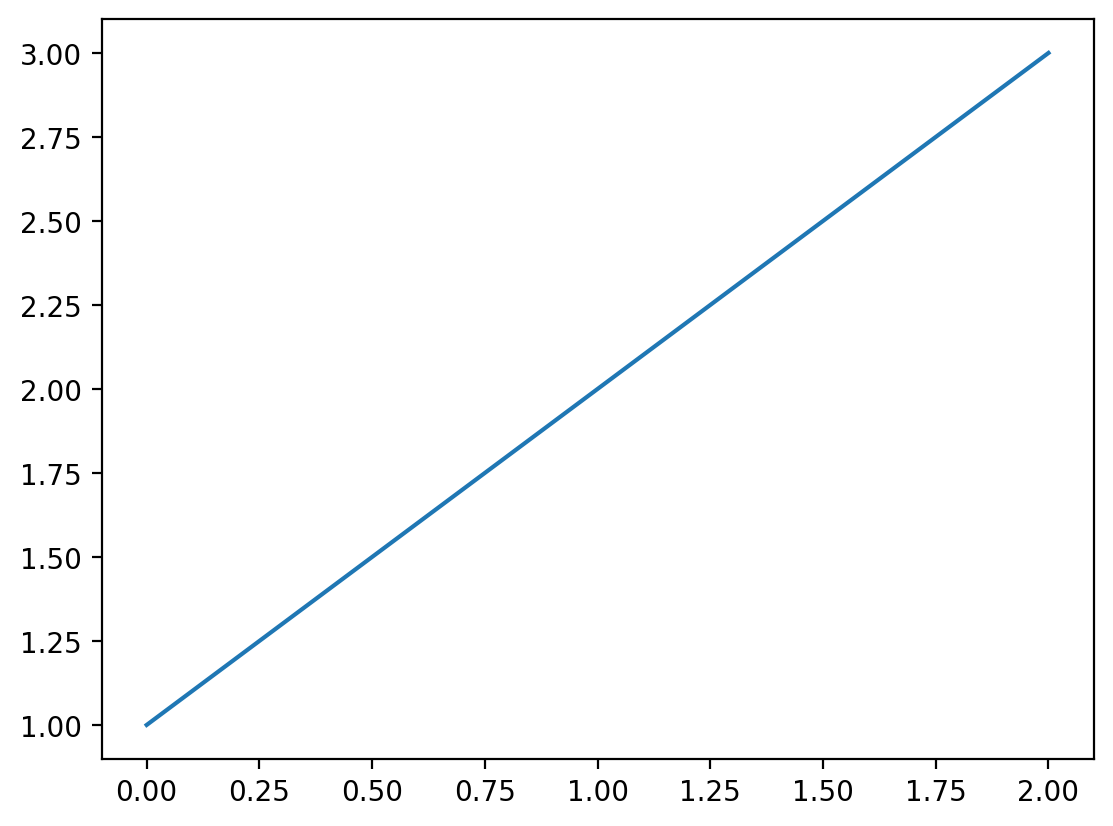

In [ ]:
o.display_objects[0]

In [ ]:
o = s.run_cell('''
import pandas as pd
pd.DataFrame({'A': [1, 2], 'B': [3, 4]})''')
o

```python
{ 'display_objects': [],
  'exception': None,
  'quiet': False,
  'result': result:    A  B
0  1  3
1  2  4; err: None; info: <cell: 
import pandas as pd
pd.DataFrame({'A': [1, 2], 'B': [3, 4]}); id: None>,
  'stderr': '',
  'stdout': ''}
```

In [ ]:
o.result.result

,A,B
0,1,3
1,2,4


In [ ]:
o = s.run_cell('1/0')
o

```python
{ 'display_objects': [],
  'exception': ZeroDivisionError('division by zero'),
  'quiet': False,
  'result': result: None; err: division by zero; info: <cell: 1/0; id: None>,
  'stderr': '',
  'stdout': '\x1b[31m---------------------------------------------------------------------------\x1b[39m\n'
            '\x1b[31mZeroDivisionError\x1b[39m                         '
            'Traceback (most recent call last)\n'
            '\x1b[36mFile '
            '\x1b[39m\x1b[32m<ipython-input-1-9e1622b385b6>:1\x1b[39m\n'
            '\x1b[32m----> \x1b[39m\x1b[32m1\x1b[39m '
            '\x1b[32;43m1\x1b[39;49m\x1b[43m/\x1b[49m\x1b[32;43m0\x1b[39;49m\n'
            '\n'
            '\x1b[31mZeroDivisionError\x1b[39m: division by zero\n'}
```

Testing errors caught after exec:

In [ ]:
o = s.run_cell('import time; time.sleep(2)', timeout=1)
test_eq(type(o['exception']), TimeoutError)

Testing errors caught before exec:

In [ ]:
o = s.run_cell('print(', timeout=1)
test_eq(isinstance(o['exception'], SyntaxError), True)
o = s.run_cell("def foo():\npass")
test_eq(isinstance(o['exception'], IndentationError), True)
o = s.run_cell("if True:\n\tpass\n        pass")
test_eq(isinstance(o['exception'], TabError), True)


### Cells / run

In [ ]:
#| export
def format_exc(e):
    "Format exception `e` as a string list"
    return traceback.format_exception(type(e), e, e.__traceback__)

In [ ]:
#| export
class NbResult(list): pass

In [ ]:
#| export
def _out_stream(text, name): return dict(name=name, output_type='stream', text=text.splitlines(True))
def _out_exc(e):
    ename = type(e).__name__
    tb = traceback.extract_tb(e.__traceback__)#.format()
    return dict(ename=str(ename), evalue=str(e), output_type='error', traceback=format_exc(e))

def _format_mimedata(k, v):
    "Format mime-type keyed data consistently with Jupyter"
    if k.startswith('text/'): return v.splitlines(True)
    if k.startswith('image/') and isinstance(v, bytes):
        v = b64encode(v).decode()
        return v+'\n' if not v.endswith('\n') else v
    return v

def _mk_out(data, meta, output_type='display_data'):
    fd = {k:_format_mimedata(k,v) for k,v in data.items()}
    return dict(data=fd, metadata=meta, output_type=output_type)

def _out_nb(o, fmt):
    res = NbResult()
    if o.stdout: res.append(_out_stream(o.stdout, 'stdout'))
    if o.stderr: res.append(_out_stream(o.stderr, 'stderr'))
    if o.exception: res.append(_out_exc(o.exception))
    res.result = o.result.result
    for x in o.display_objects: res.append(_mk_out(x.data, x.metadata))
    if res.result is not None and not o.quiet:
        res.append(_mk_out(*fmt.format(res.result), 'execute_result'))
    if 'execution_count' not in o: o['execution_count']=None
    for p in res:
        if p["output_type"]=="execute_result": p['execution_count'] = o['execution_count']
    return res

In [ ]:
#| export
@patch
def run(self:CaptureShell,
        code:str, # Python/IPython code to run
        stdout=True, # Capture stdout and save as output?
        stderr=True, # Capture stderr and save as output?
        timeout:Optional[int]=None, # Shell command will time out after {timeout} seconds
        verbose:bool=False): # Show stdout/stderr during execution
    "Run `code`, returning a list of all outputs in Jupyter notebook format"
    res = self.run_cell(code, stdout=stdout, stderr=stderr, timeout=timeout, verbose=verbose)
    self.result = res.result.result
    self.exc = res.exception
    return _out_nb(res, self.display_formatter)

In [ ]:
s = CaptureShell()

In [ ]:
s.run("print(1)")

[{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']}]

Code can include magics and `!` shell commands:

In [ ]:
o = s.run("%time 1+1")
o

[{'name': 'stdout',
  'output_type': 'stream',
  'text': ['CPU times: user 1 us, sys: 1 us, total: 2 us\n',
   'Wall time: 4.05 us\n']},
 {'data': {'text/plain': ['2']},
  'metadata': {},
  'output_type': 'execute_result',
  'execution_count': None}]

The result of the last successful execution is stored in `result`:

In [ ]:
s.result

2

A trailing `;` stops the result from being captured:

In [ ]:
s.run("1+2;")

[]

In [ ]:
o = s.run("1/0")
o

[{'name': 'stdout',
  'output_type': 'stream',
  'text': ['\x1b---------------------------------------------------------------------------\x1b\n',
   '\x1bZeroDivisionError\x1b                         Traceback (most recent call last)\n',
   '\x1bFile \x1b\x1b<ipython-input-1-9e1622b385b6>:1\x1b\n',
   '\x1b----> \x1b\x1b1\x1b \x1b1\x1b\x1b/\x1b\x1b0\x1b\n',
   '\n',
   '\x1bZeroDivisionError\x1b: division by zero\n']},
 {'ename': 'ZeroDivisionError',
  'evalue': 'division by zero',
  'output_type': 'error',
  'traceback': ['Traceback (most recent call last):\n',
   '  File "/home/radek/miniconda3/envs/kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3672, in run_code\n    exec(code_obj, self.user_global_ns, self.user_ns)\n',
   '  File "<ipython-input-1-9e1622b385b6>", line 1, in <module>\n    1/0\n    ~^~\n',
   'ZeroDivisionError: division by zero\n']}]

This is how IPython formats exceptions internally:

In [ ]:
from IPython.core.ultratb import VerboseTB

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    formatter = VerboseTB(color_scheme='Linux')

In [ ]:
try: f()
except Exception as e:
    ex = e
    print(formatter.text(type(e), e, e.__traceback__))

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[35], line 1
----> 1 try: f()
      2 except Exception as e:
      3     ex = e

NameError: name 'f' is not defined


In [ ]:
s.run("import time; time.sleep(0.1); print('no timeout')", timeout=1)

[{'name': 'stdout', 'output_type': 'stream', 'text': ['no timeout\n']}]

In [ ]:
o = s.run("import time; time.sleep(1.1)", timeout=1)
o[0]['text'][:2]

['\x1b---------------------------------------------------------------------------\x1b\n',
 '\x1bTimeoutError\x1b                              Traceback (most recent call last)\n']

In [ ]:
o1 = s.run('from IPython.display import Markdown,display; print(0); print(1); display(Markdown("*2*")); Markdown("*1*")')
o1

[{'name': 'stdout', 'output_type': 'stream', 'text': ['0\n', '1\n']},
 {'data': {'text/plain': ['<IPython.core.display.Markdown object>'],
   'text/markdown': ['*2*']},
  'metadata': {},
  'output_type': 'display_data'},
 {'data': {'text/plain': ['<IPython.core.display.Markdown object>'],
   'text/markdown': ['*1*']},
  'metadata': {},
  'output_type': 'execute_result',
  'execution_count': None}]

In [ ]:
#| export
@patch
async def run_async(self:CaptureShell,
        code: str,  # Python/IPython code to run
        stdout=True,  # Capture stdout and save as output?
        stderr=True,  # Capture stderr and save as output?
        timeout:Optional[int]=None, # Shell command will time out after {timeout} seconds
        verbose:bool=False): # Show stdout/stderr during execution
    return self.run(code, stdout=stdout, stderr=stderr, timeout=timeout, verbose=verbose)

In [ ]:
await s.run_async("1+1")

[{'data': {'text/plain': ['2']},
  'metadata': {},
  'output_type': 'execute_result',
  'execution_count': None}]

In [ ]:
#| export
def _pre(s, xtra=''): return f"<pre {xtra}><code>{escape(s)}</code></pre>"
def _strip(s): return strip_ansi(escape(s))

def render_outputs(outputs, ansi_renderer=_strip, include_imgs=True, pygments=False, md_tfm=noop, html_tfm=noop):
    try:
        from mistletoe import markdown, HTMLRenderer
        from mistletoe.contrib.pygments_renderer import PygmentsRenderer
    except ImportError: return print('mistletoe not found -- please install it for execnb.shell.render_output')
    renderer = PygmentsRenderer if pygments else HTMLRenderer
    
    def render_output(out):
        otype = out['output_type']
        if otype == 'stream':
            txt = ansi_renderer(''.join(out["text"]))
            xtra = '' if out['name']=='stdout' else "class='stderr'"
            is_err = '<span class' in txt
            return f"<pre {xtra}><code class='{'nohighlight hljs' if is_err else ''}'>{txt}</code></pre>"
        elif otype in ('display_data','execute_result'):
            data = out['data']
            _g = lambda t: ''.join(data[t]) if t in data else None
            if d := _g('text/html'): return html_tfm(d)
            if d := _g('application/javascript'): return f'<script>{d}</script>'
            if d := _g('text/markdown'): return md_tfm(markdown(d, renderer=renderer))
            if d := _g('text/latex'): return f'<div class="math">${d}$</div>'
            if include_imgs:
                if d := _g('image/jpeg'): return f'<img src="data:image/jpeg;base64,{d}"/>'
                if d := _g('image/png'): return f'<img src="data:image/png;base64,{d}"/>'
                if d := _g('image/svg+xml'): return d
            if d := _g('text/plain'): return _pre(d)
            
        return ''

    return '\n'.join(map(render_output, outputs))

In [ ]:
HTML(render_outputs(o))

We can use `ansi2html` to convert from ANSI to HTML for color rendering.  You need some [css styles](https://github.com/fastai/fastcore/blob/master/examples/ansi.css) for the colors to render properly.  Jupyter already has these built in so it's not neccessary here, but if you plan on using this in another web app you will need to ensure that css styling is included.

In [ ]:
HTML(render_outputs(o, ansi2html))

Images and matplotlib figures are captured:


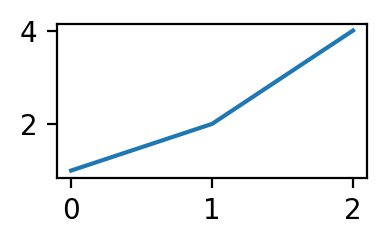

In [ ]:
res = s.run('''import matplotlib.pyplot as plt
plt.figure(figsize=(2,1))
plt.plot([1,2,4]);''')

HTML(render_outputs(res))

If an exception is raised then the exception type, object, and stacktrace are stored in `exc`:

In [ ]:
o = s.run('raise Exception("Oops")')
o

[{'name': 'stdout',
  'output_type': 'stream',
  'text': ['\x1b---------------------------------------------------------------------------\x1b\n',
   '\x1bException\x1b                                 Traceback (most recent call last)\n',
   '\x1bFile \x1b\x1b<ipython-input-1-01648acb07bd>:1\x1b\n',
   '\x1b----> \x1b\x1b1\x1b \x1braise\x1b \x1bException\x1b(\x1b"\x1b\x1bOops\x1b\x1b"\x1b)\n',
   '\n',
   '\x1bException\x1b: Oops\n']},
 {'ename': 'Exception',
  'evalue': 'Oops',
  'output_type': 'error',
  'traceback': ['Traceback (most recent call last):\n',
   '  File "/home/radek/miniconda3/envs/kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3672, in run_code\n    exec(code_obj, self.user_global_ns, self.user_ns)\n',
   '  File "<ipython-input-1-01648acb07bd>", line 1, in <module>\n    raise Exception("Oops")\n',
   'Exception: Oops\n']}]

In [ ]:
s.exc

Exception('Oops')

In [ ]:
#| export
@patch
def cell(self:CaptureShell, cell, stdout=True, stderr=True, verbose=False):
    "Run `cell`, skipping if not code, and store outputs back in cell"
    if cell.cell_type!='code': return
    self._cell_idx = cell.idx_ + 1
    outs = self.run(cell.source, verbose=verbose)
    if outs: cell.outputs = _dict2obj(outs)

In [ ]:
clean = Path('../tests/clean.ipynb')
nb = read_nb(clean)
c = nb.cells[1]
c

```json
{ 'cell_type': 'code',
  'execution_count': None,
  'id': 'b123d6d0',
  'idx_': 1,
  'metadata': {},
  'outputs': [],
  'source': 'print(1)\n2'}
```

In [ ]:
s.cell(c)
c.outputs

[{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']},
 {'data': {'text/plain': ['2']},
  'metadata': {},
  'output_type': 'execute_result',
  'execution_count': None}]

In [ ]:
#| export
def find_output(outp, # Output from `run`
                ot='execute_result' # Output_type to find
               ):
    "Find first output of type `ot` in `CaptureShell.run` output"
    return first(o for o in outp if o['output_type']==ot)

In [ ]:
find_output(c.outputs)['data']

```json
{'text/plain': ['2']}
```

In [ ]:
find_output(c.outputs, 'stream')['text']

['1\n']

In [ ]:
#| export
def out_exec(outp):
    "Get data from execution result in `outp`."
    out = find_output(outp)
    if out: return '\n'.join(first(out['data'].values()))

In [ ]:
out_exec(c.outputs)

'2'

In [ ]:
#| export
def out_stream(outp):
    "Get text from stream in `outp`."
    out = find_output(outp, 'stream')
    if out: return ('\n'.join(out['text'])).strip()

In [ ]:
out_stream(c.outputs)

'1'

In [ ]:
#| export
def out_error(outp):
    "Get traceback from error in `outp`."
    out = find_output(outp, 'error')
    if out: return '\n'.join(out['traceback'])

### NBs -

In [ ]:
#| export
def _false(o): return False

@patch
def run_all(self:CaptureShell,
            nb, # A notebook read with `nbclient` or `read_nb`
            exc_stop:bool=False, # Stop on exceptions?
            preproc:callable=_false, # Called before each cell is executed
            postproc:callable=_false, # Called after each cell is executed
            inject_code:str|None=None, # Code to inject into a cell
            inject_idx:int=0, # Cell to replace with `inject_code`
            verbose:bool=False # Show stdout/stderr during execution
           ):
    "Run all cells in `nb`, stopping at first exception if `exc_stop`"
    if inject_code is not None: nb.cells[inject_idx].source = inject_code
    for cell in nb.cells:
        if not preproc(cell):
            self.cell(cell, verbose=verbose)
            postproc(cell)
        if self.exc and exc_stop: raise self.exc from None

In [ ]:
nb.cells[2].outputs

[]

In [ ]:
s.run_all(nb)
nb.cells[2].outputs

[{'data': {'text/plain': ['<IPython.core.display.Markdown object>'],
   'text/markdown': ["This is *bold*. Here's a [link](https://www.fast.ai)."]},
  'metadata': {},
  'output_type': 'execute_result',
  'execution_count': None}]

With `exc_stop=False` (the default), execution continues after exceptions, and exception details are stored into the appropriate cell's output:

In [ ]:
nb.cells[-1].source

'raise Exception("Oopsie!")'

In [ ]:
nb.cells[-1].outputs

[{'name': 'stdout',
  'output_type': 'stream',
  'text': ['\x1b---------------------------------------------------------------------------\x1b\n',
   '\x1bException\x1b                                 Traceback (most recent call last)\n',
   '\x1bFile \x1b\x1b<ipython-input-1-1c97c1d317ab>:1\x1b\n',
   '\x1b----> \x1b\x1b1\x1b \x1braise\x1b \x1bException\x1b(\x1b"\x1b\x1bOopsie!\x1b\x1b"\x1b)\n',
   '\n',
   '\x1bException\x1b: Oopsie!\n']},
 {'ename': 'Exception',
  'evalue': 'Oopsie!',
  'output_type': 'error',
  'traceback': ['Traceback (most recent call last):\n',
   '  File "/home/radek/miniconda3/envs/kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3672, in run_code\n    exec(code_obj, self.user_global_ns, self.user_ns)\n',
   '  File "<ipython-input-1-1c97c1d317ab>", line 1, in <module>\n    raise Exception("Oopsie!")\n',
   'Exception: Oopsie!\n']}]

With `exc_stop=True`, exceptions in a cell are raised and no further processing occurs:

In [ ]:
try: s.run_all(nb, exc_stop=True)
except Exception as e: print(f"got exception: {e}")

got exception: Oopsie!


We can pass a function to `preproc` to have it run on every cell. It can modify the cell as needed. If the function returns `True`, then that cell will not be executed. For instance, to skip the cell which raises an exception:

In [ ]:
nb = read_nb(clean)
s.run_all(nb, preproc=lambda c: 'raise' in c.source)

This cell will contain no output, since it was skipped.

In [ ]:
nb.cells[-1].outputs

[]

In [ ]:
nb.cells[1].outputs

[{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']},
 {'data': {'text/plain': ['2']},
  'metadata': {},
  'output_type': 'execute_result',
  'execution_count': None}]

You can also pass a function to `postproc` to modify a cell after it is executed.

In [ ]:
#| export
@patch
def execute(self:CaptureShell,
            src:str|Path, # Notebook path to read from
            dest:str|None=None, # Notebook path to write to
            exc_stop:bool=False, # Stop on exceptions?
            preproc:callable=_false, # Called before each cell is executed
            postproc:callable=_false, # Called after each cell is executed
            inject_code:str|None=None, # Code to inject into a cell
            inject_path:str|Path|None=None, # Path to file containing code to inject into a cell
            inject_idx:int=0, # Cell to replace with `inject_code`
            verbose:bool=False # Show stdout/stderr during execution
):
    "Execute notebook from `src` and save with outputs to `dest"
    nb = read_nb(src)
    self._fname = src
    self.set_path(Path(src).parent.resolve())
    if inject_path is not None: inject_code = Path(inject_path).read_text()
    self.run_all(nb, exc_stop=exc_stop, preproc=preproc, postproc=postproc,
                 inject_code=inject_code, inject_idx=inject_idx, verbose=verbose)
    if dest: write_nb(nb, dest)

This is a shortcut for the combination of `read_nb`, `CaptureShell.run_all`, and `write_nb`.

In [ ]:
s = CaptureShell()
try:
    s.execute(clean, 'tmp.ipynb')
    print(read_nb('tmp.ipynb').cells[1].outputs)
finally: Path('tmp.ipynb').unlink()

[{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']}, {'data': {'text/plain': ['2']}, 'execution_count': None, 'metadata': {}, 'output_type': 'execute_result'}]


In [ ]:
p = Path.home()/'git'/'fastcore'/'nbs'
n = p/'03a_parallel.ipynb'

In [ ]:
#| export
@patch
def prettytb(self:CaptureShell, 
             fname:str|Path=None): # filename to print alongside the traceback
    "Show a pretty traceback for notebooks, optionally printing `fname`."
    fname = fname if fname else self._fname
    _fence = '='*75
    cell_intro_str = f"While Executing Cell #{self._cell_idx}:" if self._cell_idx else "While Executing:"
    cell_str = f"\n{cell_intro_str}\n{''.join(format_exc(self.exc))}"
    fname_str = f' in {fname}' if fname else ''
    return f"{type(self.exc).__name__}{fname_str}:\n{_fence}\n{cell_str}\n"

If an error occurs while running a notebook, you can retrieve a pretty version of the error with the `prettytb` method: 

In [ ]:
s = CaptureShell()
try:
    s.execute('../tests/error.ipynb', exc_stop=True)
except:
    print(s.prettytb())

AssertionError in ../tests/error.ipynb:

While Executing Cell #2:
Traceback (most recent call last):
  File "/tmp/ipykernel_1087357/1421292703.py", line 3, in <module>
    s.execute('../tests/error.ipynb', exc_stop=True)
  File "/tmp/ipykernel_1087357/3276016238.py", line 19, in execute
    self.run_all(nb, exc_stop=exc_stop, preproc=preproc, postproc=postproc,
  File "/tmp/ipykernel_1087357/3244179380.py", line 20, in run_all
    if self.exc and exc_stop: raise self.exc from None
                              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/radek/miniconda3/envs/kaggle/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3672, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-b968a57a586e>", line 3, in <module>
    foo()
  File "/home/radek/workspace/execnb/tests/err.py", line 2, in foo
    assert 13 == 98
           ^^^^^^^^
AssertionError




### Tests -

In [ ]:
#| hide
# Trailing `;` stops data from being captured
res = CaptureShell().run('1+1;')
test_eq(res, [])

# Newlines, whitespace, and comments after `;` are ignored
# TODO: fix test
# res = CaptureShell().run('1+1;\n  #commented_func()')
test_eq(res, [])

In [ ]:
#| hide
# Streams are split on and keep newlines
res = CaptureShell().run(r"print('a\nb'); print('c\n\n'); print('d')")
test_eq(res[0]['text'], ['a\n', 'b\n', 'c\n', '\n', '\n', 'd\n'])

In [ ]:
#| hide
# Text mime data are split on and keep newlines
res = CaptureShell().run(r"from IPython.display import Markdown; display(Markdown('a\nb'))")
test_eq(res[0]['data']['text/markdown'], ['a\n', 'b'])

In [ ]:
#| hide
# Binary image mime data are base64-encoded and end in a single `\n`

def _pil2b64(im): return b64encode(im._repr_png_()).decode()+'\n'
im = Image.new('RGB', (3,3), 'red')
imb64 = _pil2b64(im)

res = CaptureShell().run("from PIL import Image; Image.new('RGB', (3,3), 'red')")
test_eq(res[0]['data']['image/png'], imb64)

In [ ]:
#| hide
# `display_data` flushes stdout and stderr - in that order
res = CaptureShell().run("import sys; sys.stderr.write('Error!'); print(1); display(1)")
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']},
              {'name': 'stderr', 'output_type': 'stream', 'text': ['Error!']},
              {'data': {'text/plain': ['1']}, 'metadata': {}, 'output_type': 'display_data'}])

In [ ]:
#| hide
# Consecutive writes to stdout are grouped
res = CaptureShell().run('print(1); print(2); print(3)')
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n', '2\n', '3\n']}])

In [ ]:
#| hide
# Consecutive writes to stdout are grouped despite an intermediate write to stderr, which is captured after
res = CaptureShell().run("import sys; print(1); print(2); sys.stderr.write('Error!'); print(3)")
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n', '2\n', '3\n']},
              {'name': 'stderr', 'output_type': 'stream', 'text': ['Error!']}])

In [ ]:
#| hide
# `execute_result` is always last
res = CaptureShell().run("import sys; sys.stderr.write('Error!'); print(1); display(1); 1")
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']},
              {'name': 'stderr', 'output_type': 'stream', 'text': ['Error!']},
              {'data': {'text/plain': ['1']}, 'metadata': {}, 'output_type': 'display_data'},
              {'data': {'text/plain': ['1']}, 'metadata': {}, 'output_type': 'execute_result', 'execution_count': None}])

## Params -

If you pass `inject_code` to `CaptureShell.execute` or `CaptureShell.run_all`, the source of `nb.cells[inject_idx]` will be replaced with `inject_code`. By default, the first cell is replaced. For instance consider this notebook:

In [ ]:
nb = read_nb('../tests/params.ipynb')
for c in nb.cells: print('- ',c.source)

-  a=1
-  print(a)


We can replace the first cell with `a=2` by passing that as `inject_code`, and the notebook will run with that change:

In [ ]:
nb = read_nb('../tests/params.ipynb')
s.run_all(nb, inject_code="a=2")
list(nb.cells)

[{'cell_type': 'code',
  'execution_count': None,
  'id': 'a63ce885',
  'metadata': {},
  'outputs': [],
  'source': 'a=2',
  'idx_': 0},
 {'cell_type': 'code',
  'execution_count': None,
  'id': 'ea528db5',
  'metadata': {},
  'outputs': [{'name': 'stdout', 'output_type': 'stream', 'text': ['2\n']}],
  'source': 'print(a)',
  'idx_': 1}]

This can be used with `CaptureShell.execute` to parameterise runs of models in notebooks. Place any defaults for configuration code needed in the first cell, and then when running `execute` pass in new parameters as needed in `inject_code`. To replace only some of the defaults, leave an empty cell as the second cell, and inject code using `inject_idx=1` to replace the empty second cell with code that overrides some of the defaults set in the first cell. When using `execute` you can pass `inject_path` instead of `inject_code` to read the injected code from a file.

## cli -

In [ ]:
#| export
@call_parse
def exec_nb(
    src:str, # Notebook path to read from
    dest:str='', # Notebook path to write to
    exc_stop:bool=False, # Stop on exceptions?
    inject_code:str=None, # Code to inject into a cell
    inject_path:str=None, # Path to file containing code to inject into a cell
    inject_idx:int=0, # Cell to replace with `inject_code`
    verbose:bool=False # Show stdout/stderr during execution
):
    "Execute notebook from `src` and save with outputs to `dest`"
    CaptureShell().execute(src, dest, exc_stop=exc_stop, inject_code=inject_code,
                           inject_path=inject_path, inject_idx=inject_idx, verbose=verbose)

This is the command-line version of `CaptureShell.execute`. Run `exec_nb -h` from the command line to see how to pass arguments. If you don't pass `dest` then the output notebook won't be saved; this is mainly useful for running tests.

## Completions -

In [ ]:
#| export
class SmartCompleter(IPCompleter):
    def __init__(self, shell, namespace=None, jedi=False):
        if namespace is None: namespace = shell.user_ns
        super().__init__(shell, namespace)
        self.use_jedi = jedi
        sdisp = StrDispatch()
        self.custom_completers = sdisp
        import_disp = CommandChainDispatcher()
        import_disp.add(types.MethodType(module_completer, shell))
        sdisp.add_s('import', import_disp)
        sdisp.add_s('from', import_disp)

    def __call__(self, c):
        if not c: return []
        with provisionalcompleter():
            res = [o.text.rpartition('.')[-1] for o in self.completions(c, len(c)) if o.type!='magic']
        if res and res[0][-1]=='=': res = [o for o in res if o[-1]=='=']
        return res

In [ ]:
cc = SmartCompleter(get_ipython())

def test_set(a,b): return test_eq(set(a), set(b))

class _f:
    def __init__(self): self.bar,self.baz,self.room = 0,0,0

foo = _f()

assert set(cc("b")).issuperset(['bool', 'bytes'])
test_set(cc("foo.b"), ['bar', 'baz'])
test_set(cc("x=1; x = foo.b"), ['bar', 'baz'])
test_set(cc("ab"), ['abs'])
test_set(cc("b = ab"), ['abs'])
test_set(cc(""), [])
test_set(cc("foo."), ['bar', 'baz', 'room'])
test_set(cc("nonexistent.b"), [])
test_set(cc("foo.nonexistent.b"), [])
assert set(cc("import ab")).issuperset(['abc'])
test_set(cc("from abc import AB"), ['ABC', 'ABCMeta'])

In [ ]:
s = CaptureShell()
cc = SmartCompleter(s)
s.run('''def captures(pat, s, n, **kw):
    return 1''')
cc('captures(')

['n=', 'pat=', 's=']

In [ ]:
#| export
@patch
def complete(self:CaptureShell, c):
    if not hasattr(self, '_completer'): self._completer = SmartCompleter(self)
    return self._completer(c)

In [ ]:
s = CaptureShell()
s.run('a=1')
s.complete('a.b')

['bit_count', 'bit_length']

In [ ]:
s.run('import re')
s.complete('re.compile(')

['flags=', 'pattern=']

## export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()